In [1]:
import os
import cv2
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
from livelossplot import PlotLosses

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
from cnn.Model import EESPNet_Reg

In [3]:
class PredModel(torch.nn.Module):
    def __init__(self, pred_dim, n_out):
        super(PredModel, self).__init__()
        
        # Prediciton layers
        self.cnn_layers = []
        for i in range(len(pred_dim) - 1):
            cnn_layer = nn.Sequential(
                nn.Conv1d(pred_dim[i][0], pred_dim[i + 1][0], 3),
                nn.LeakyReLU(),
                nn.Dropout(pred_dim[i + 1][1])
            )
            self.cnn_layers.append(cnn_layer)
        self.cnn_layers.append(nn.AdaptiveMaxPool1d(1))
        self.cnn_layers = nn.Sequential(*self.cnn_layers)
        self.pred_layer = nn.Linear(pred_dim[-1][0], n_out)
        

    def forward(self, feats):
        pred = self.cnn_layers(feats)
        pred = pred.view(pred.shape[0], -1)
        pred = self.pred_layer(pred)
        return(pred)


In [17]:
class GradientAscent:

    def __init__(self, model, lr=1):
        self.model = model
        self.lr = lr

        self.num_layers = len(list(self.model.named_children()))
        self.activation = None

        self.handlers = []
        self.output = None
    
    def optimize(self, x, idx, num_iter=30):

        img_var = Variable(x, requires_grad=True)  # convert image to Variable that requires grad
        optimizer = torch.optim.Adam([img_var], lr=self.lr)
        liveloss = PlotLosses()

        for n in range(num_iter):  # optimize pixel values for opt_steps times
            
            pred = self.model(img_var)
            optimizer.zero_grad()
            loss = - pred[0][0][idx]
            loss.backward()
            optimizer.step()
            
            
            liveloss.update({'loss': loss.data.item()})
            liveloss.draw()

            
        return(img_var)
    
    

In [18]:
fct_dim = [16, 8, 4]
fct_dropout = 0.1
fct_dim = [[x, fct_dropout] for x in fct_dim]

n_out = 5
# Atribui o modelo
modelp = PredModel(fct_dim, n_out)
modelp = modelp.to(device)
modelp.load_state_dict(torch.load('../data/PredModel_tmp.pth',map_location=device), strict=False)


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [19]:
# Atribui o modelo
model = EESPNet_Reg(n_out = 5, s = 0.5)
model = model.to(device)
model.load_state_dict(torch.load('../data/FeatModel_tmp.pth' ,map_location=device), strict=False)


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

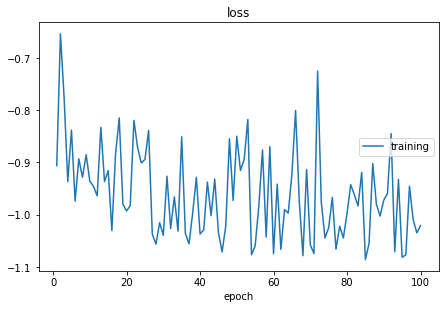

loss:
training   (min:   -1.086, max:   -0.654, cur:   -1.021)


In [43]:
idx = 2
tst_input = torch.randn((1, 3, 40, 80)).cuda()

grad = GradientAscent(model, lr = 1)
output = grad.optimize(tst_input, idx,  100)


In [44]:
model(output)[0][0][idx]

tensor(0.9828, device='cuda:0', grad_fn=<SelectBackward>)

In [45]:
imgout = output[0].cpu().data.numpy()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


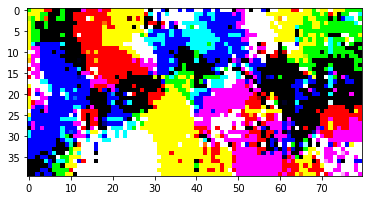

In [46]:
plt.imshow(np.moveaxis(imgout, 0, 2))